In [1]:
### RECOVERED-CW.IPYNB -- example of simple continuous gravitational-wave parameter estimation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

In [3]:
# constants

G = 6.67e-8 # Newton's constant in cgs
c = 2.998e10 # speed of light in cgs
kpc = 3.086e21 # kiloparsec in cm

In [4]:
# define continuous gravitational waveform template

frot_inj = 182.

def hplus(t,h0plus,f0,f0dot):
    
    return h0plus*np.cos(np.pi*f0dot*t**2 + 2.*np.pi*f0*t)

def hcross(t,h0cross,f0,f0dot,alpha):
    
    return h0cross*np.cos(np.pi*f0dot*t**2 + 2.*np.pi*f0*t + alpha)

def Fplus(theta,phi): # from Maggiore p. 342
    
    return 0.5*(1.+np.cos(theta)**2)*np.cos(2.*phi)

def Fcross(theta,phi): # from Maggiore p. 342
    
    return np.cos(theta)*np.sin(2.*phi)

def theta(t,theta0):
    
    return theta0 #+2*np.pi*t/(24.*60.*60)

def phi(t,phi0):
    
    return phi0 #+2.*np.pi*t/(24.*60.*60.)

def h(t,h0plus,h0cross,f0,f0dot,alpha,theta0,phi0):
    
    return Fplus(theta(t,theta0),phi(t,phi0))*hplus(t,h0plus,f0,f0dot) + Fcross(theta(t,theta0),phi(t,phi0))*hcross(t,h0cross,f0,f0dot,alpha)

def ht(t,fdot,e,dL=10.*kpc,i=0.,frot=frot_inj,theta0=np.pi/4.,phi0=0.):

    f0 = 2.*frot
    I = 1e45

    h0 = 4.*np.pi**2*G*I*f0**2*e/(c**4*dL)
    h0plus = h0*(1.+np.cos(i)**2)/2.
    h0cross = h0*np.cos(i)*(1.+np.cos(i)**2)/2.
    alpha = np.pi/2.

    return h(t,h0plus,h0cross,f0,fdot,alpha,theta0,phi0)

In [5]:
filepath = 'simple-cw-master/'
filename = 'cw_' + 'example' + '.csv'

ts = []
hs = []

with open(filepath + filename) as file:
    raw_read = csv.reader(file)
    next(raw_read)
    for row in raw_read:
        # f_rot.append(float(row[0]))
        ts.append(float(row[0]))
        hs.append(float(row[1]))
        
ts = np.array(ts)
hs = np.array(hs)

In [6]:
# define Gaussian likelihood function, up to normalization

fdot_inj = 2e-4
e_inj = 5e-6

fmin, fmax = (1e-4,10e-4)
emin, emax = (1e-6,10e-6)

def log_prior(fdot,e): # uniform prior in e and fdot
    
    return np.where(fdot > fmin and fdot <= fmax and e > emin and e <= emax, 0., -np.inf)

def log_like(fdot,e,hs=hs,ts=ts): # Gaussian likelihood function
    
    sqrtSn = 2e-25
    
    res = hs-ht(ts,fdot,e) # time domain signal minus template residual
    #res_fd = np.fft.fft(res) # frequency domain residual
    
    #inner_prod = 2.*np.real(np.sum(res_fd*np.conjugate(res_fd)/sqrtSn**2))

    return -0.5*np.sum(4.*frot_inj**2*res**2/(sqrtSn**2))/len(res) #-0.5*inner_prod

def log_post(fdot,e,hs=hs,ts=ts):
    
    return log_like(fdot,e,hs,ts)+log_prior(fdot,e)

8.128043847423738e-06 0.0002544774258400248


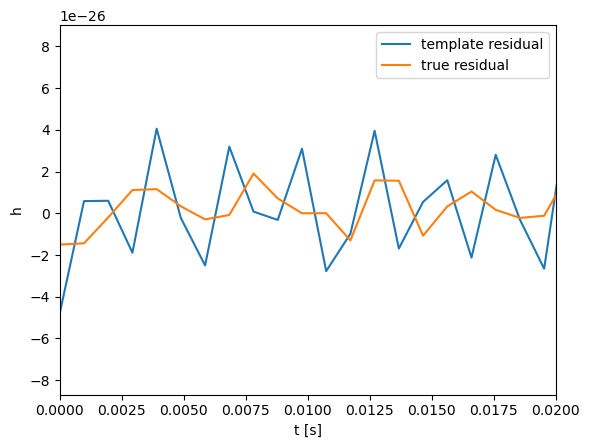

In [7]:
# plot signal minus template residual for a random choice of parameters, and compare to noise residual

e_samp = float(np.random.uniform(emin,emax,1))
fdot_samp = float(np.random.uniform(fmin,fmax,1))
print(e_samp,fdot_samp)

plt.plot(ts,hs-ht(ts,fdot_samp,e_samp),label='template residual')
plt.plot(ts,hs-ht(ts,fdot_inj,e_inj),label='true residual')

plt.xlim(0.,4./200.)
plt.xlabel('t [s]')
plt.ylabel('h')
plt.legend()

plt.show()

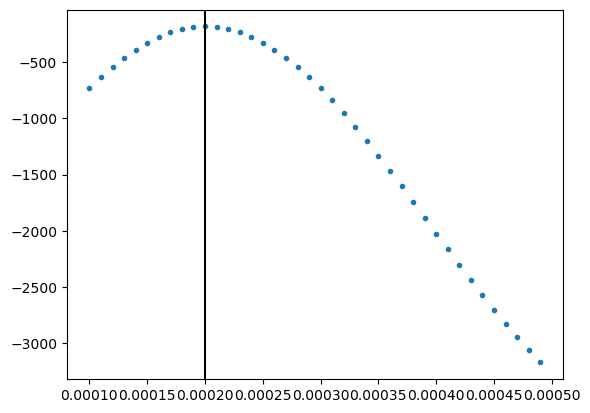

In [8]:
plt.scatter(np.arange(1e-4,5e-4,1e-5),[log_like(fdot,e_inj) for fdot in np.arange(1e-4,5e-4,1e-5)],marker='.')
plt.axvline(fdot_inj,0.,1.,c='k')
plt.show()

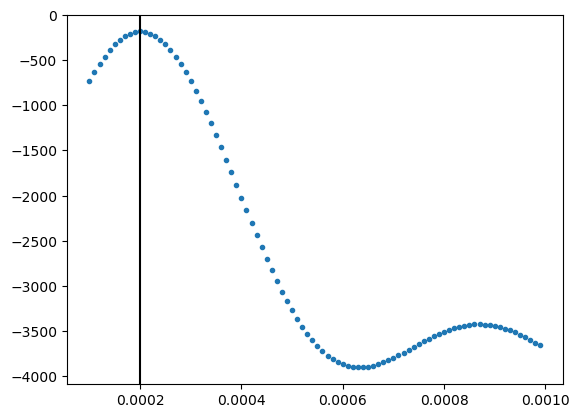

In [9]:
plt.scatter(np.arange(1e-4,10e-4,1e-5),[log_like(fdot,e_inj) for fdot in np.arange(1e-4,10e-4,1e-5)],marker='.')
plt.axvline(fdot_inj,0.,1.,c='k')
plt.show()

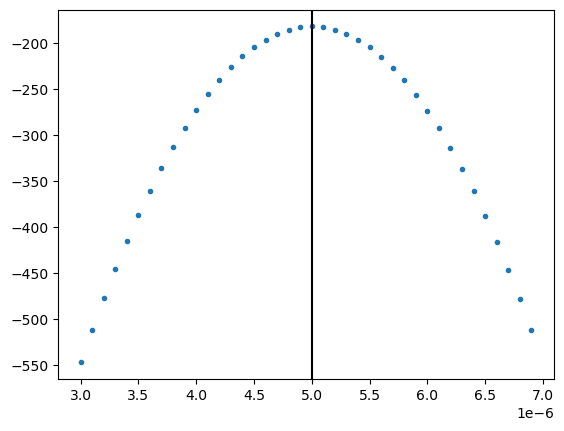

In [10]:
plt.scatter(np.arange(3e-6,7e-6,1e-7),[log_like(fdot_inj,e) for e in np.arange(3e-6,7e-6,1e-7)],marker='.')
plt.axvline(e_inj,0.,1.,c='k')
plt.show()

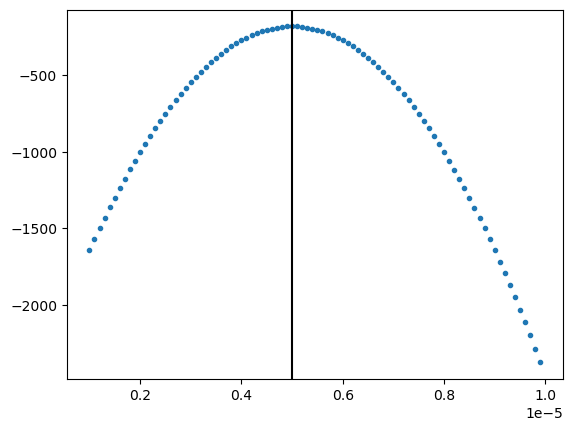

In [11]:
plt.scatter(np.arange(1e-6,10e-6,1e-7),[log_like(fdot_inj,e) for e in np.arange(1e-6,10e-6,1e-7)],marker='.')
plt.axvline(e_inj,0.,1.,c='k')
plt.show()

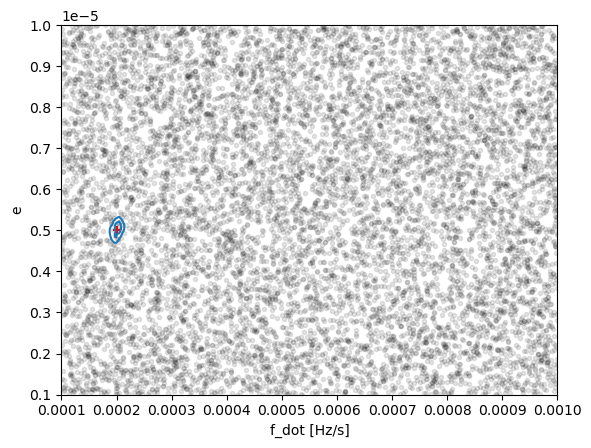

In [12]:
nsamps = int(1e4)
fdot_samps = np.random.uniform(fmin,fmax,nsamps)
e_samps = np.random.uniform(emin,emax,nsamps)

log_posts = []

for fdot,e in zip(fdot_samps,e_samps):
    
    log_post_val = log_post(fdot,e,hs,ts)
    
    if np.isnan(log_post_val):
        
        log_posts += [-1e100]
        print('nan',fdot,e)
        
    else:
        
        log_posts += [log_post_val]

posts = np.exp(np.array(log_posts))
posts /= np.sum(posts)

plt.scatter(fdot_samps,e_samps,marker='.',c='k',alpha=0.1)
sns.kdeplot(x=fdot_samps,y=e_samps,weights=posts,levels=[0.1,0.5])

plt.scatter(fdot_inj,e_inj,c='r',marker='+')

plt.xlim(fmin,fmax)
plt.ylim(emin,emax)
plt.xlabel('f_dot [Hz/s]')
plt.ylabel('e')

plt.show()

In [13]:
import emcee

def log_prior(vec): # uniform prior in e and fdot
    
    fdot, e = vec
    
    return np.where(fdot > fmin and fdot <= fmax and e > emin and e <= emax, 0., -np.inf)

def log_like(vec,hs=hs,ts=ts): # Gaussian likelihood function
    
    fdot, e = vec
    
    sqrtSn = 2e-25
    
    res = hs-ht(ts,fdot,e) # time domain signal minus template residual

    return -0.5*np.sum(4.*frot_inj**2*res**2/(sqrtSn**2))/len(res) #-0.5*inner_prod

def log_post(vec,hs=hs,ts=ts):
    
    fdot, e = vec
    
    return log_like(vec,hs,ts)+log_prior(vec)

N_WALKERS = 5
N_POSTS = 10000
N_BURNIN = 50

e_samps = np.random.uniform(2.*emin,0.5*emax,N_WALKERS) # trim the range for starting values to be half the prior
fdot_samps = np.random.uniform(2.*fmin,0.5*fmax,N_WALKERS)
ini_samps = np.array([[fdot_samps[samp_ind], e_samps[samp_ind]] for samp_ind in range(N_WALKERS)])
print(ini_samps)
ndims = ini_samps.shape[1] # number of pop params to infer
print('dimensions:', ndims)

sampler = emcee.EnsembleSampler(N_WALKERS, ndims, log_post, args=()) # initialize emcee sampler
sampler.run_mcmc(ini_samps, N_POSTS+N_BURNIN);

acls = sampler.get_autocorr_time(discard=N_BURNIN,quiet=True)
print('autocorrelation lengths:', acls)

samples_emcee = sampler.chain[:, N_BURNIN::int(max(acls)), :].reshape((-1, ndims))

[[4.41828802e-04 3.06147380e-06]
 [2.62906486e-04 4.23152753e-06]
 [2.01173928e-04 2.76123562e-06]
 [2.28146618e-04 2.41998556e-06]
 [3.11797474e-04 2.60264593e-06]]
dimensions: 2
autocorrelation lengths: [41.59723554 36.2820977 ]


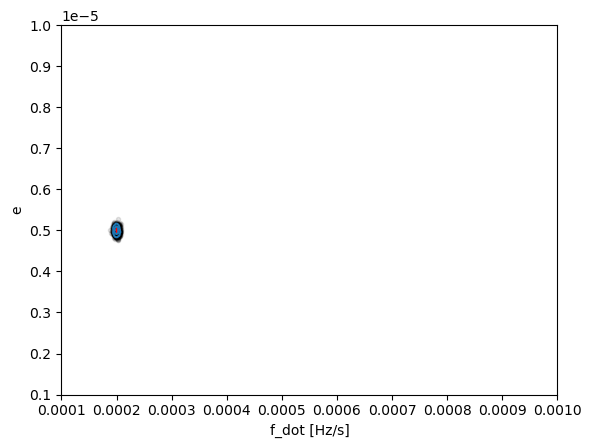

In [14]:
plt.scatter(samples_emcee[:,0],samples_emcee[:,1],marker='.',c='k',alpha=0.1)
plt.scatter(fdot_inj,e_inj,marker='+',c='r')
sns.kdeplot(x=samples_emcee[:,0],y=samples_emcee[:,1],levels=[0.1,0.5])

plt.xlim(fmin,fmax)
plt.ylim(emin,emax)
plt.xlabel('f_dot [Hz/s]')
plt.ylabel('e')
plt.show()